In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import product
import copy
import os
import sys

repo_root = os.path.abspath("..")
sys.path.append(repo_root)

import train
from dataset import myDataset
from lstm import myLSTM
from utils import load_config

### load device, datasets, config into environment.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = myDataset(device, 5)
test_dataset = myDataset(device, 5, False)


config_path = os.path.join(repo_root, "config.yaml")
base_config = load_config(config_path)

### General Hyperparam sweep

In [4]:
lr_list = [1e-3, 5e-4]
batch_sizes = [32, 64]
hidden_sizes = [64, 128, 256]
training_results = dict()

for lr, bs, hs in product(lr_list, batch_sizes, hidden_sizes):
    config = copy.deepcopy(base_config)
    
    config["training"]["lr"] = lr
    config["training"]["batch_size"] = bs
    config["model"]["hidden_size"] = hs
    
    config["experiment_name"] = f"lr{lr}_bs{bs}_hs{hs}"
    model = myLSTM(**config["model"]).to(device)
    training_results[config["experiment_name"]] = \
    train.fit_lstm(model, config["experiment_name"], train_dataset, test_dataset, **config["training"])
    print()
    

| experiment: lr0.001_bs32_hs64 | epoch 10, train: MSE 0.0204, test MSE: 0.0329
update LR: 0.001 -> 0.0005
| experiment: lr0.001_bs32_hs64 | epoch 20, train: MSE 0.0126, test MSE: 0.0163
update LR: 0.0005 -> 0.00025
| experiment: lr0.001_bs32_hs64 | epoch 30, train: MSE 0.0112, test MSE: 0.0141
update LR: 0.00025 -> 0.000125
| experiment: lr0.001_bs32_hs64 | epoch 40, train: MSE 0.0108, test MSE: 0.0133
update LR: 0.000125 -> 6.25e-05
| experiment: lr0.001_bs32_hs64 | epoch 50, train: MSE 0.0107, test MSE: 0.0130
update LR: 6.25e-05 -> 3.125e-05
update LR: 3.125e-05 -> 1.5625e-05
| experiment: lr0.001_bs32_hs64 | epoch 60, train: MSE 0.0106, test MSE: 0.0126
update LR: 1.5625e-05 -> 7.8125e-06
update LR: 7.8125e-06 -> 3.90625e-06
| experiment: lr0.001_bs32_hs64 | epoch 65, train: MSE 0.0106, test MSE: 0.0126
Stopping early

| experiment: lr0.001_bs32_hs128 | epoch 10, train: MSE 0.0205, test MSE: 0.0389
update LR: 0.001 -> 0.0005
| experiment: lr0.001_bs32_hs128 | epoch 20, train: MSE 

### Comparing test losses

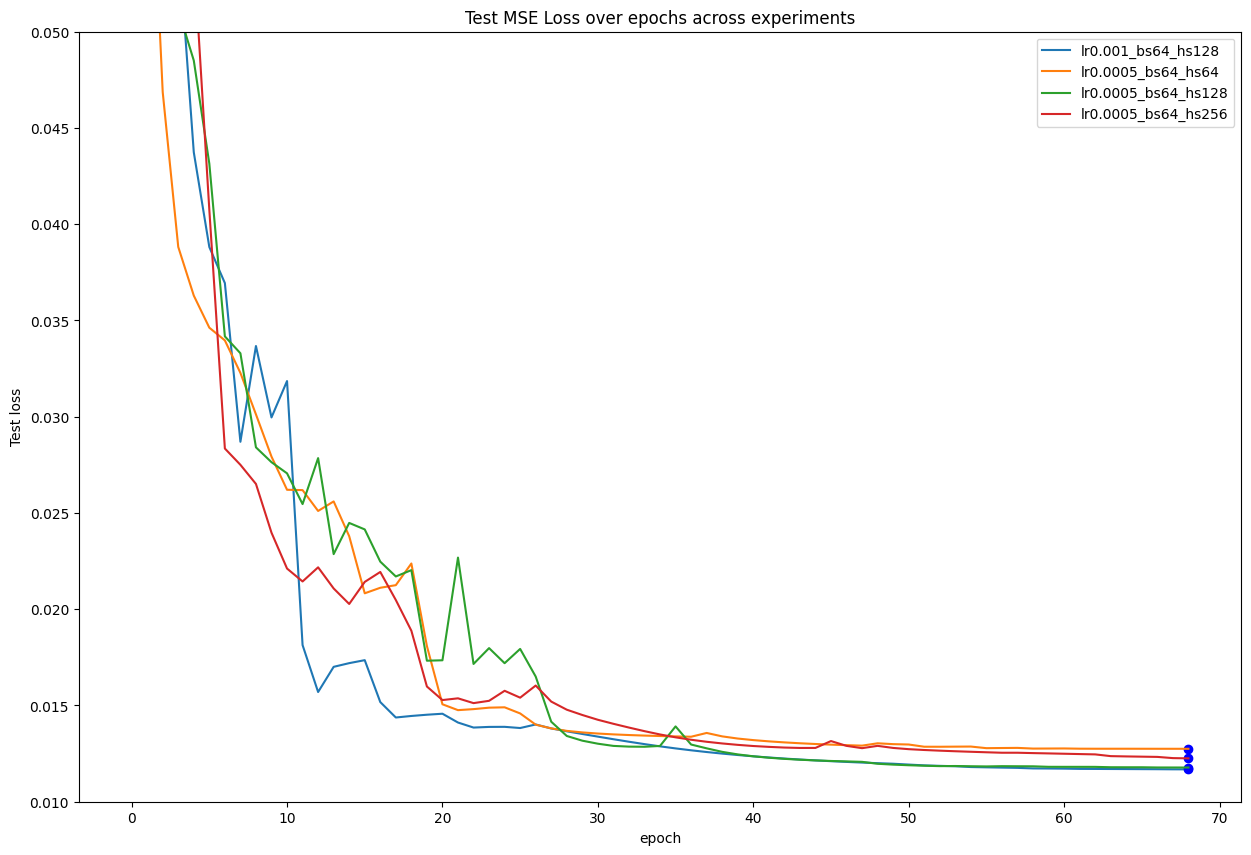

In [74]:
plt.figure(figsize=(15, 10))
colors = plt.cm.tab20(np.linspace(0, 1, len(training_results)))
for ex_name, result in training_results.items():
    test_array = result[2]
    if len(test_array) == 69:
        plt.plot(np.argmin(test_array), np.min(test_array), 'o', c = "blue")
        plt.plot(range(config["training"]["num_epochs"] - 1), 
                 test_array,
                label = ex_name)
plt.ylim(0.01, 0.05)
plt.xlabel("epoch")
plt.ylabel("Test loss")
plt.title("Test MSE Loss over epochs across experiments")
plt.legend()
plt.show()

### Based on the graph, hs = 128 seems to be the sweet spot. Batch sizes could be made bigger (since bs64 dominates bs32). Learning rate should be tested more.

In [73]:
# Not increasing LR for larger batches, because experiments show that model plateaus quite early on, and LR needs to be lower
lr_list = [5e-4, 2.5e-4] 
batch_sizes = [128, 256]
hidden_sizes = [128]
training_results_2 = dict()

for lr, bs, hs in product(lr_list, batch_sizes, hidden_sizes):
    config2 = copy.deepcopy(base_config)
    
    config2["training"]["lr"] = lr
    config2["training"]["batch_size"] = bs
    config2["model"]["hidden_size"] = hs
    config2["training"]["num_epochs"] = 100
    config2["experiment_name"] = f"lr{lr}_bs{bs}_hs{hs}"
    model = myLSTM(**config2["model"]).to(device)
    training_results_2[config2["experiment_name"]] = \
    train.fit_lstm(model, config2["experiment_name"], train_dataset, test_dataset, **config2["training"])
    print()
    

| experiment: lr0.0005_bs128_hs128 | epoch 10, train: MSE 0.0171, test MSE: 0.0260
update LR: 0.0005 -> 0.00025
| experiment: lr0.0005_bs128_hs128 | epoch 20, train: MSE 0.0126, test MSE: 0.0171
| experiment: lr0.0005_bs128_hs128 | epoch 30, train: MSE 0.0122, test MSE: 0.0165
update LR: 0.00025 -> 0.000125
update LR: 0.000125 -> 6.25e-05
update LR: 6.25e-05 -> 3.125e-05
| experiment: lr0.0005_bs128_hs128 | epoch 40, train: MSE 0.0109, test MSE: 0.0141
| experiment: lr0.0005_bs128_hs128 | epoch 50, train: MSE 0.0107, test MSE: 0.0133
update LR: 3.125e-05 -> 1.5625e-05
| experiment: lr0.0005_bs128_hs128 | epoch 60, train: MSE 0.0107, test MSE: 0.0130
update LR: 1.5625e-05 -> 7.8125e-06
update LR: 7.8125e-06 -> 3.90625e-06
update LR: 3.90625e-06 -> 1.953125e-06
| experiment: lr0.0005_bs128_hs128 | epoch 67, train: MSE 0.0106, test MSE: 0.0130
Stopping early

| experiment: lr0.0005_bs256_hs128 | epoch 10, train: MSE 0.0186, test MSE: 0.0361
update LR: 0.0005 -> 0.00025
| experiment: lr0.0

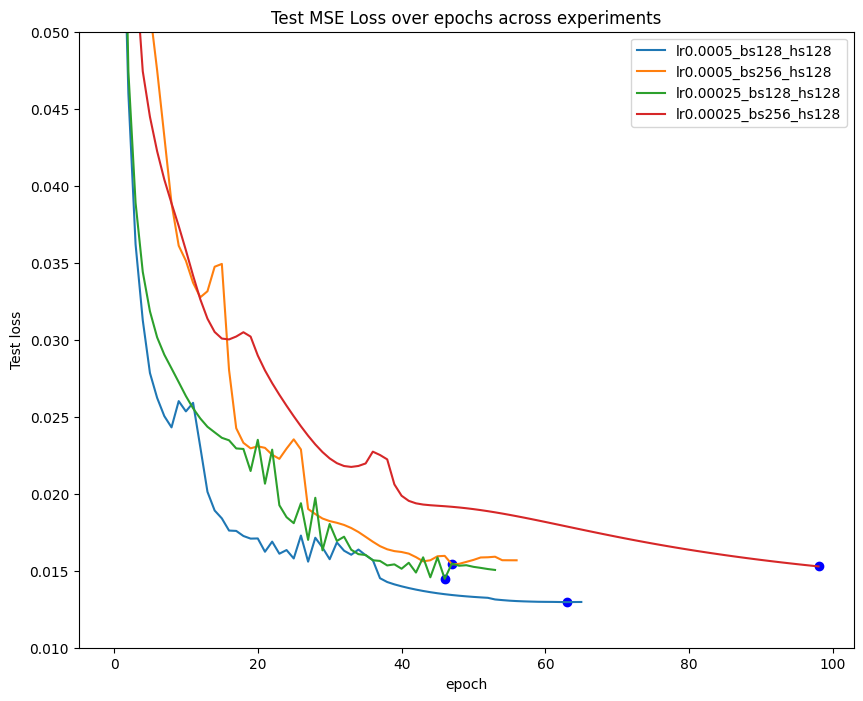

In [77]:
plt.figure(figsize=(10, 8))
for ex_name, result in training_results_2.items():
    test_array = result[2]
    plt.plot(np.argmin(test_array), np.min(test_array), 'o', c = "blue")
    plt.plot(range(config2["training"]["num_epochs"]), 
             np.pad(test_array, pad_width=(0, 100 - len(test_array)), mode='constant', constant_values=np.nan),
            label = ex_name)
plt.ylim(0.01, 0.05)
plt.xlabel("epoch")
plt.ylabel("Test loss")
plt.title("Test MSE Loss over epochs across experiments")
plt.legend()
plt.show()

### No significant improvement for larger batch sizes for this config. Sticking to 64 batches, hidden_size of 128, and initial lr or 0.0005. <br> Since I'm not going for best accuracy/performance, this is good enough.

In [81]:
final_results = dict()
final_config = copy.deepcopy(base_config)

final_config["training"]["lr"] = 0.001
final_config["training"]["batch_size"] = 64
final_config["training"]["num_epochs"] = 200
final_config["model"]["hidden_size"] = 128

final_config["experiment_name"] = f"lr{0.001}_bs{64}_hs{128}"
final_short_window_lstm = myLSTM(**final_config["model"]).to(device)
final_results[final_config["experiment_name"]] = \
train.fit_lstm(final_short_window_lstm, final_config["experiment_name"], 
               train_dataset, test_dataset, **final_config["training"])
print()

| experiment: lr0.001_bs64_hs128 | epoch 10, train: MSE 0.0213, test MSE: 0.0342
update LR: 0.001 -> 0.0005
| experiment: lr0.001_bs64_hs128 | epoch 20, train: MSE 0.0129, test MSE: 0.0173
update LR: 0.0005 -> 0.00025
update LR: 0.00025 -> 0.000125
| experiment: lr0.001_bs64_hs128 | epoch 30, train: MSE 0.0110, test MSE: 0.0133
| experiment: lr0.001_bs64_hs128 | epoch 40, train: MSE 0.0107, test MSE: 0.0124
update LR: 0.000125 -> 6.25e-05
update LR: 6.25e-05 -> 3.125e-05
| experiment: lr0.001_bs64_hs128 | epoch 50, train: MSE 0.0106, test MSE: 0.0122
update LR: 3.125e-05 -> 1.5625e-05
update LR: 1.5625e-05 -> 7.8125e-06
| experiment: lr0.001_bs64_hs128 | epoch 60, train: MSE 0.0105, test MSE: 0.0120
update LR: 7.8125e-06 -> 3.90625e-06
update LR: 3.90625e-06 -> 1.953125e-06
update LR: 1.953125e-06 -> 9.765625e-07
| experiment: lr0.001_bs64_hs128 | epoch 70, train: MSE 0.0105, test MSE: 0.0119
update LR: 9.765625e-07 -> 4.8828125e-07
| experiment: lr0.001_bs64_hs128 | epoch 71, train: M

### 

## Looking at model outputs

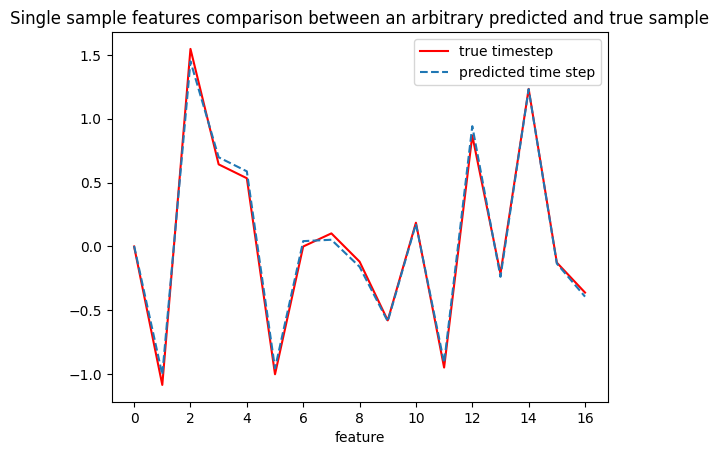

In [99]:
with torch.no_grad():
    random_idx = 8534
    random_pred = final_short_window_lstm(test_dataset[random_idx][0].unsqueeze(dim = 0))
    real = test_dataset[random_idx][1]
plt.plot(real.cpu().detach().numpy(), c = "red", label = "true timestep")
plt.plot(random_pred.cpu().detach().numpy()[0], label = "predicted time step", linestyle = 'dashed')
plt.xlabel("feature")
plt.legend()
plt.title("Single sample features comparison between an arbitrary predicted and true sample")
plt.show()

## Now for all data points, requires dimensionality reduction. Choosing 3d to preserve the most variance possible.

In [85]:
y_true_array = test_dataset.y.cpu().detach().numpy()
y_pred_array = final_short_window_lstm(test_dataset.X).cpu().detach().numpy()
pca = PCA(n_components = 3)
true_3d = pca.fit_transform(y_true_array)
pred_3d = pca.transform(y_pred_array)
print(pca.explained_variance_ratio_.sum())

0.73677164


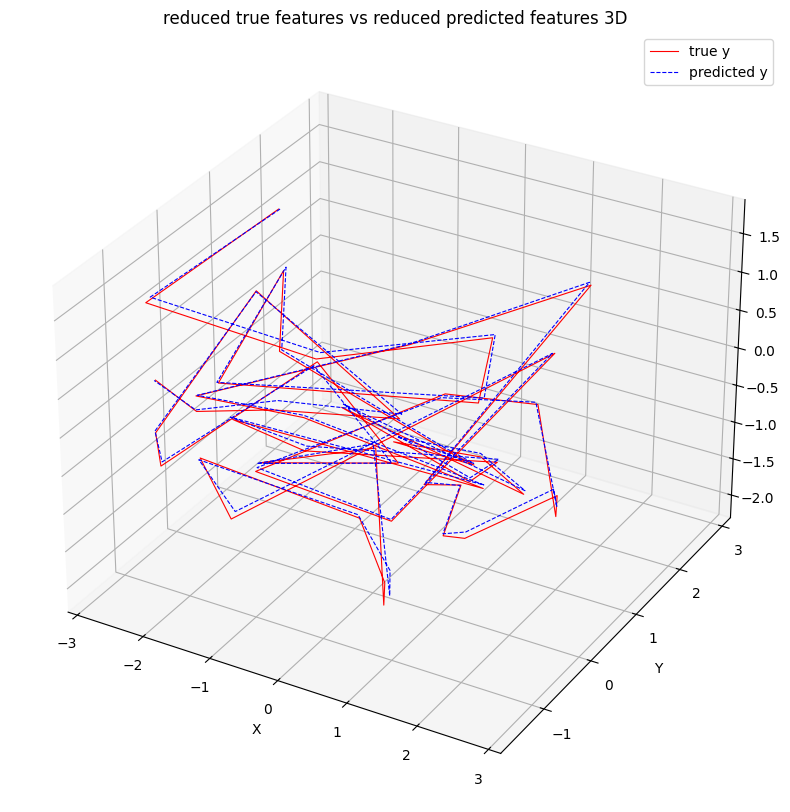

In [87]:
step = 200
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d') 

ax.plot(true_3d[::step,0], true_3d[::step,1], true_3d[::step,2], c='r', linewidth=0.8, label = "true y")
ax.plot(pred_3d[::step,0], pred_3d[::step,1], pred_3d[::step,2], c='b', linewidth=0.8, linestyle = 'dashed', label = "predicted y")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('reduced true features vs reduced predicted features 3D')
plt.legend()
plt.show()

### Save the model weights

In [ ]:
save_dir = os.path.join(repo_root, "saved_model_weights")
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "short_window_LSTM_weights.pth")
torch.save(final_short_window_lstm.state_dict(), save_path)